In [1]:
!pip install botorch
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 481 kB 30.5 MB/s 
     |████████████████████████████████| 727 kB 63.3 MB/s 
     |████████████████████████████████| 152 kB 76.9 MB/s 
     |████████████████████████████████| 245 kB 111.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.3 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 24.5 MB/s 


In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import rdmolfiles, rdmolops, AllChem, Draw, rdDepictor, Descriptors
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Fingerprints import FingerprintMols

from IPython.display import SVG
from IPython.display import HTML
from IPython.display import display

import torch
from botorch.models import SingleTaskGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from botorch.models.multitask import MultiTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.optim import Adam
from collections import defaultdict
from tqdm import tqdm

#**Load Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
f = pd.read_csv("./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Data/Training_data(MF_RDKit_full data).csv")

In [5]:
f

,1,64,80,170,175,226,247,341,356,389,...,fr_thiophene,fr_unbrch_alkane,fr_urea,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.11406,0.15000,82.81,1,21.34
1,1,3,1,1,2,2,1,1,1,1,...,0,0,0,17500,1.06,0.18196,0.23366,80.00,1,21.18
2,1,3,1,1,2,2,1,1,1,1,...,0,0,0,78800,1.12,0.00632,0.00700,0.10,1,73.99
3,1,3,1,1,2,2,1,1,1,1,...,0,0,0,22100,1.03,0.11401,0.15300,1.02,1,27.42
4,1,3,1,1,2,2,1,1,1,1,...,0,0,0,13500,1.06,0.17990,0.17990,4.35,1,6.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.44220,0.50560,0.10,0,63.14
4829,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.09225,0.11590,0.10,0,71.08
4830,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.11156,0.13940,0.10,0,72.63
4831,0,0,3,0,0,2,1,0,0,0,...,0,0,0,50000,1.50,0.34850,0.40830,0.10,0,73.50


Feature scaling

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
f_std = f.copy()
f_std.iloc[:, :-1] = scaler.fit_transform(f_std.iloc[:, :-1])

In [7]:
print(f_std.shape)
f_std.head()

(4833, 342)


,1,64,80,170,175,226,247,341,356,389,...,fr_thiophene,fr_unbrch_alkane,fr_urea,Mw(Da),PDI,ϕ,w,P(Mpa),1-Phase,CP(°C)
0,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,0.0,-0.276705,0.0,-0.531646,-0.548048,0.036676,0.145899,5.774263,0.782696,21.34
1,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,0.0,-0.276705,0.0,-0.531646,-0.548048,0.657195,0.846006,5.564014,0.782696,21.18
2,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,0.0,-0.276705,0.0,-0.323328,-0.484995,-0.947929,-1.050794,-0.414228,0.782696,73.99
3,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,0.0,-0.276705,0.0,-0.516014,-0.579574,0.036219,0.171004,-0.345393,0.782696,27.42
4,0.415898,0.759158,-0.28004,0.659527,0.759158,0.0,-0.273039,0.81713,0.62692,0.759158,...,0.0,-0.276705,0.0,-0.545239,-0.548048,0.638369,0.396117,-0.096237,0.782696,6.08


# **Model Building**

In [8]:
from sklearn.model_selection import train_test_split

X = f_std.iloc[:, :-1].values
y = f_std.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [9]:
# A list for the evaluation result
rmse_sum = {}
r2_sum = {}

## Lasso

In [10]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.661e+04, tolerance: 2.318e+03
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [11]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, lasso.predict(X_train))
RMSE_train = mean_squared_error(y_train, lasso.predict(X_train), squared=False)
R_square_test = r2_score(y_test, lasso.predict(X_test))
RMSE_test = mean_squared_error(y_test, lasso.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8363779487445491
RMSE(Train): 31.320497260429644

R_square(Test): 0.8431474584289332
RMSE(Test): 30.162755151283122


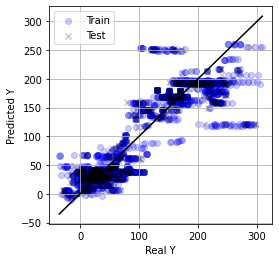

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, lasso.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, lasso.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [13]:
rmse_sum['Linear Regression(Lasso)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(Lasso)'] = [R_square_train, R_square_test] 

## Ridge

In [14]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [15]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, ridge.predict(X_train))
RMSE_train = mean_squared_error(y_train, ridge.predict(X_train), squared=False)
R_square_test = r2_score(y_test, ridge.predict(X_test))
RMSE_test = mean_squared_error(y_test, ridge.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8478829095501659
RMSE(Train): 30.199290312267575

R_square(Test): 0.8509286912349691
RMSE(Test): 29.405072922880013


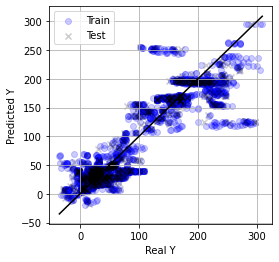

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, ridge.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, ridge.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [17]:
rmse_sum['Linear Regression(Ridge)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(Ridge)'] = [R_square_train, R_square_test] 

## ElasticNet

In [18]:
from sklearn.linear_model import ElasticNet
EN = ElasticNet(alpha=0.1)
EN.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.256e+04, tolerance: 2.318e+03
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.1)

In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, EN.predict(X_train))
RMSE_train = mean_squared_error(y_train, EN.predict(X_train), squared=False)
R_square_test = r2_score(y_test, EN.predict(X_test))
RMSE_test = mean_squared_error(y_test, EN.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.8309655409643091
RMSE(Train): 31.834303770464167

R_square(Test): 0.83809613876016
RMSE(Test): 30.644591167732486


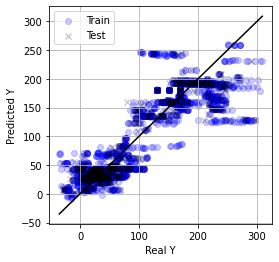

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, EN.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, EN.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [21]:
rmse_sum['Linear Regression(ElasticNet)'] = [RMSE_train, RMSE_test] 
r2_sum['Linear Regression(ElasticNet)'] = [R_square_train, R_square_test] 

## RF

In [22]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [23]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, rf.predict(X_train))
RMSE_train = mean_squared_error(y_train, rf.predict(X_train), squared=False)
R_square_test = r2_score(y_test, rf.predict(X_test))
RMSE_test = mean_squared_error(y_test, rf.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9995817014189741
RMSE(Train): 1.5836198169320876

R_square(Test): 0.997966559824672
RMSE(Test): 3.4343213401841455


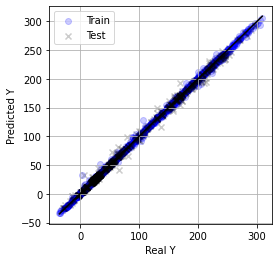

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, rf.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, rf.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [25]:
rmse_sum['RF'] = [RMSE_train, RMSE_test]
r2_sum['RF'] = [R_square_train, R_square_test] 

## SVR

In [26]:
# from sklearn.svm import SVR
# svr = SVR()
# svr.fit(X_train, y_train)

In [27]:
# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_squared_error

# R_square_train = r2_score(y_train, svr.predict(X_train))
# RMSE_train = mean_squared_error(y_train, svr.predict(X_train), squared=False)
# R_square_test = r2_score(y_test, svr.predict(X_test))
# RMSE_test = mean_squared_error(y_test, svr.predict(X_test), squared=False)

# print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
# print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

In [28]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(4,4))
# plt.scatter(y_train, svr.predict(X_train), alpha=0.2, c="blue", label='Train')
# plt.scatter(y_test, svr.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
# plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
# plt.legend()
# plt.grid()
# plt.xlabel("Real Y")
# plt.ylabel("Predicted Y")
# plt.show()

In [29]:
# rmse_sum['SVR'] = [RMSE_train, RMSE_test] 
# r2_sum['SVR'] = [R_square_train, R_square_test] 

## LGB

In [30]:
import lightgbm as lgb
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train, y_train)

LGBMRegressor()

In [31]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

R_square_train = r2_score(y_train, lgb_reg.predict(X_train))
RMSE_train = mean_squared_error(y_train, lgb_reg.predict(X_train), squared=False)
R_square_test = r2_score(y_test, lgb_reg.predict(X_test))
RMSE_test = mean_squared_error(y_test, lgb_reg.predict(X_test), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9970218083130239
RMSE(Train): 4.22555788699151

R_square(Test): 0.994961061204273
RMSE(Test): 5.406233138070131


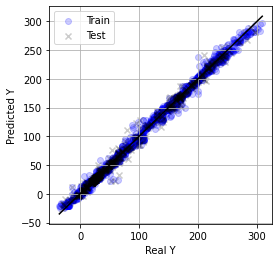

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train, lgb_reg.predict(X_train), alpha=0.2, c="blue", label='Train')
plt.scatter(y_test, lgb_reg.predict(X_test), alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [33]:
rmse_sum['LGB'] = [RMSE_train, RMSE_test] 
r2_sum['LGB'] = [R_square_train, R_square_test] 

## Gp(BoTorch)

In [34]:
from sklearn.model_selection import train_test_split

X = f.iloc[:, :-1].values
y = f.iloc[:, -1].values

#Seperating literature data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)


In [35]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# X must be in the range=(0, 1)
# use MinMaxScaler to transform features
mmscaler = MinMaxScaler()
X_train_mm = mmscaler.fit_transform(X_train)
X_test_mm = mmscaler.transform(X_test)


X_train_tensor = torch.from_numpy(np.array(X_train_mm))
X_test_tensor = torch.from_numpy(np.array(X_test_mm))


# Y must be in the range=(-1, 1)
y_scaler = StandardScaler()

y_train_s = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_s = y_scaler.transform(y_test.reshape(-1, 1))

y_train_tensor = torch.from_numpy(np.array(y_train_s))
y_test_tensor = torch.from_numpy(np.array(y_test_s))

In [36]:
kernel = RBFKernel(ard_num_dims=X.shape[1])

gp = SingleTaskGP(X_train_tensor, y_train_tensor, covar_module=kernel)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): RBFKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
  )
)

In [37]:
# import pickle

# with open('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Trained_model/gp_trained_model(MF_RDKit Descriptor_Full data).pkl', mode='wb') as f:
#   pickle.dump(gp,f)

In [38]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_train_pred = gp.posterior(X_train_tensor).mean.detach().numpy().copy()
y_train_var = gp.posterior(X_train_tensor).variance.detach().numpy().copy()

y_test_pred = gp.posterior(X_test_tensor).mean.detach().numpy().copy()
y_test_var = gp.posterior(X_test_tensor).variance.detach().numpy().copy()

R_square_train = r2_score(y_train_s, y_train_pred)
RMSE_train = mean_squared_error(y_scaler.inverse_transform(y_train_s), y_scaler.inverse_transform(y_train_pred), squared=False)
R_square_test = r2_score(y_test_s, y_test_pred)
RMSE_test = mean_squared_error(y_scaler.inverse_transform(y_test_s), y_scaler.inverse_transform(y_test_pred), squared=False)

print(f'R_square(Train): {R_square_train}\nRMSE(Train): {RMSE_train}\n')
print(f'R_square(Test): {R_square_test}\nRMSE(Test): {RMSE_test}')

R_square(Train): 0.9849468565853767
RMSE(Train): 9.499950266460704

R_square(Test): 0.984132736387489
RMSE(Test): 9.593481603541017


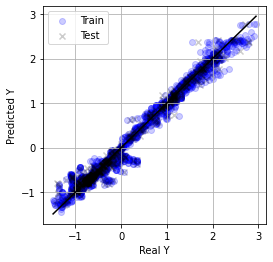

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(y_train_s, y_train_pred, alpha=0.2, c="blue", label='Train')
plt.scatter(y_test_s, y_test_pred, alpha=0.2, c="black", marker='x', label='Test')
plt.plot([y_train_s.min(), y_train_s.max()], [y_train_s.min(), y_train_s.max()], c="black")
plt.legend()
plt.grid()
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()

In [40]:
rmse_sum['GP'] = [RMSE_train, RMSE_test] 
r2_sum['GP'] = [R_square_train, R_square_test] 

# **Summary**

In [41]:
summary = pd.DataFrame(rmse_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of RMSE")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,LGB,GP
Train,31.320497,30.199290,31.834304,1.583620,4.225558,9.499950
Test,30.162755,29.405073,30.644591,3.434321,5.406233,9.593482


In [42]:
summary = pd.DataFrame(r2_sum, index=['Train', 'Test'])
summary.style.set_caption("Table of R square")

,Linear Regression(Lasso),Linear Regression(Ridge),Linear Regression(ElasticNet),RF,LGB,GP
Train,0.836378,0.847883,0.830966,0.999582,0.997022,0.984947
Test,0.843147,0.850929,0.838096,0.997967,0.994961,0.984133


# **Feature Importance**

Text(0.5, 0, 'Feature Importance')

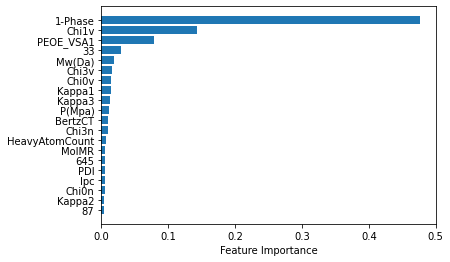

In [45]:
#w/o ϕ
sort = rf.feature_importances_.argsort()
plt.barh(f_std.iloc[:, :-1].columns[sort].astype(str)[-20:], rf.feature_importances_[sort][-20:])
plt.xlabel("Feature Importance")

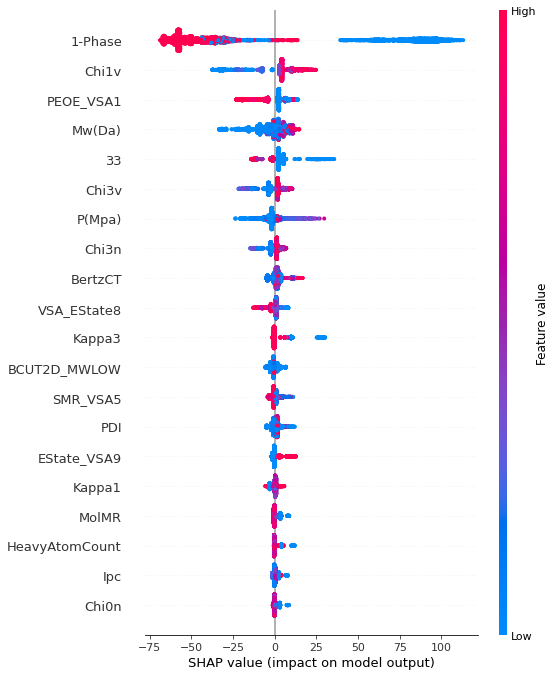

In [46]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model=rf, feature_perturbation='tree_path_dependent', model_output='margin')
shap_values = explainer.shap_values(X=f_std.iloc[:, :-1])
shap.summary_plot(shap_values, f_std.iloc[:, :-1])

# **Feature Selection (remove later)**

Low Variance Filter

In [ ]:
from copy import copy

thresheld = 0.1  #10%

data = copy(pd.DataFrame(X)) #only check X variables
var = data.var()
X_col = data.columns
variable = X_col[var >=thresheld] #find columns to keep
data = data[variable]

print (data.shape)

(4833, 61)


High Correlation Filter

In [ ]:
#Filter Method is the first step to perform when selecting features.
from copy import copy

thresheld = 0.8

# data = copy(fp_com) #Stacking with low variance filter
corr_matrix = data.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #using 'where' and input array to choose a specific cell in dataframe
to_drop = [column for column in upper.columns if any(upper[column] >= thresheld)] #find columns to drop
data = data.drop(columns = to_drop) 

print (data.shape)

(4833, 27)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
# data.to_csv('./drive/MyDrive/AI/Material Informatics (MI)/Polymer Cloud Point QSAR/Binary Polymer Solution Cloud Point Data/Training Data/Feature selected data(MF_RDKit Descriptor_1-Phase dropped).csv')